# 目的是研究边缘态在adiabatic 下的演化 以及在存在dissipation下的 情况

In [1]:
import numpy as np
import random
random.uniform(-np.pi/20, np.pi/20)

-0.03390045376302303

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
 
def carry(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def blue_carry(state, theta):
	'''
	blue carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number plus 1
	|1>-->|0>, phonon number minus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, down level minus 1
	up_state = carry_state_up[0]
	down_state_minus = carry_state_up[1]
	down_state_minus_0 = state_up[0][0]  # blue carry can not drive the phonon=0 && up level
	down_state_minus = np.delete(down_state_minus, 0)
	down_state_minus = np.insert(down_state_minus, len(down_state_minus)-1, 0)
	# after U operation, up level plus 1
	up_state_plus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_plus = np.insert(up_state_plus, 0, down_state_minus_0)
	up_state_plus = np.delete(up_state_plus, len(up_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_plus
	down = down_state_minus + down_state
	final_state = np.vstack((up, down))

	return final_state

def red_carry(state, theta):
	'''
	red carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number minus 1
	|1>-->|0>, phonon number plus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, up level minus 1
	up_state_minus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_minus_0 = state_down[1][0] # red carry can not drive the phonon=0 && down level
	up_state_minus = np.delete(up_state_minus,0)
	up_state_minus = np.insert(up_state_minus,len(up_state_minus)-1,0)
	# after U operation, down level plus 1
	up_state = carry_state_up[0]
	down_state_plus = carry_state_up[1]
	down_state_plus = np.insert(down_state_plus,0,up_state_minus_0)
	down_state_plus = np.delete(down_state_plus,len(down_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_minus
	down = down_state_plus + down_state
	final_state = np.vstack((up, down))

	return final_state

def Operator(up_state, down_state, func, theta):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = func(state, theta)
	return state[0], state[1]


def one_step(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step_1(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):      
		state = one_step(state, theta_1, theta_2)
	return state

def N_step_dis(state, theta_1, theta_2, dis, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		t1 = theta_1 + random.uniform(-dis, dis)
		t2 = theta_2 + random.uniform(-dis, dis)        
		state = one_step(state, t1, theta_2)
	return state

def N_step_dis_1(state, theta_1, theta_2, dis, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		t1 = theta_1 + random.uniform(-dis, dis)
		t2 = theta_2 + random.uniform(-dis, dis)        
		state = one_step(state, t1, t2)
	return state

In [7]:
M = 100

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_1 = np.linspace(-2*np.pi, 2*np.pi, 201)
theta_2 = np.pi/2
dis = np.pi/5
p = np.zeros(201)

for i,theta in enumerate(theta_1):
    state = N_step_dis_1(init_state, theta, theta_2, dis,  N=30)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p[i] = P[0] + P[1] 


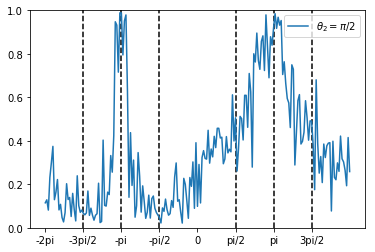

In [8]:
plt.plot(theta_1, p, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

# 绝热演化
$\theta(t)=\frac{\theta_{\max }+\theta_{\min }}{2}+\frac{\theta_{\max }-\theta_{\min }}{2} \tanh \left(\frac{t}{\xi}\right)$
和之前在不同区间的转角不同类似，我们在时域上采用类似的演化，显然$\chi$改变决定不同的速度

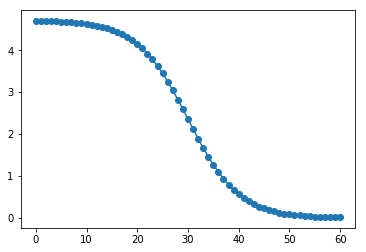

In [580]:
# 波形 ,theta_1 为后半段转角，theta_2 为前半段转角，xi越小演化越慢
n = 30
def f(t, theta_1, theta_2, xi, n):
    return 1/2*(theta_1+theta_2 + (theta_1-theta_2)*np.tanh((t-n)/xi))
T = np.linspace(0,2*n,2*n+1)
th = np.zeros(2*n+1)
for i,t in enumerate(T):
    th[i] = f(t, 0, 3*np.pi/2, 10 ,n)
plt.scatter(T,th)
plt.plot(T,th)

In [365]:
# def N_step_ada(state, theta_1, theta_2, theta_3, xi, n1, n2):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(n1):
# 		t = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n1)/xi))       
# 		state = one_step(state, t, theta_2)
# 	for i in range(n2):
# 		t = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi))       
# 		state = one_step(state, t, theta_2)    
# 	return state

# def N_step_Ada(state, theta_1, theta_2, theta_3, xi, n1, n2):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(n1):
# 		t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n1)/xi))       
# 		state = one_step(state, theta_1, t)
# 	for i in range(n2):
# 		t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi))       
# 		state = one_step(state, theta_1, t)    
# 	return state
def N_step_ada(state, theta_1, theta_2, theta_3, xi, dis, n1, n2, n3):
	'''
	N step of complete quantum walk
	'''
	for i in range(n1):    
		state = one_step(state, theta_1, theta_2)     
	for i in range(n2):
		t = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi))       
		state = one_step(state, t, theta_2)
	for i in range(n3):
		t = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi))       
		state = one_step(state, t+random.uniform(-dis, dis), theta_2)    
	return state

def N_step_Ada(state, theta_1, theta_2, theta_3, xi, n1, n2, n3):
	'''
	N step of complete quantum walk
	'''
	for i in range(n1):    
		state = one_step(state, theta_1, theta_2)     
	for i in range(n2):
		t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi))       
		state = one_step(state, theta_1, t)
	for i in range(n3):
		t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i+1)/xi))       
		state = one_step(state, theta_1, t)    
	return state

In [386]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = np.linspace(-3*np.pi/2, 3*np.pi/2, 201)
theta_1 = -np.pi/2
theta_2 = np.pi/4

p_1 = np.zeros(201)
p_2 = np.zeros(201)
p_3 = np.zeros(201)
p_4 = np.zeros(201)

dis = np.pi/10

for i,theta in enumerate(theta_3):
    state = N_step_Ada(init_state, theta_1, theta_2, theta, 0.25,  n1=20, n2=20, n3=100)
    P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_1[i] = P1[0] + P1[1] 
    state = N_step_Ada(init_state, theta_1, theta_2, theta, 1,  n1=15, n2=25, n3=100)
    P2 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_2[i] = P2[0] + P2[1]
    state = N_step_Ada(init_state, theta_1, theta_2, theta, 4,  n1=10, n2=30, n3=100)
    P3 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_3[i] = P3[0] + P3[1]
    state = N_step_Ada(init_state, theta_1, theta_2, theta, 8,   n1=5, n2=35, n3=100)
    P4 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_4[i] = P4[0] + P4[1]


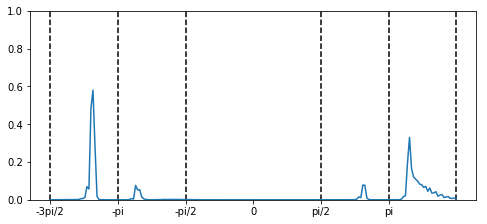

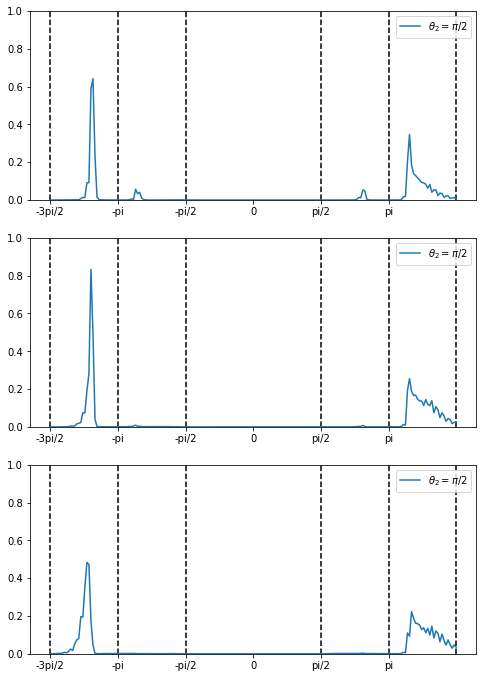

In [387]:
plt.figure(figsize=(8,16))
plt.subplot(4,1,1)
plt.plot(theta_3, p_1, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-3*np.pi/2,3*np.pi/2,np.pi/2) 
# my_x_ticks = np.arange(-5*np.pi/2,np.pi/2,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.xticks(my_x_ticks,('-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2'))
# plt.xticks(my_x_ticks,('-5pi/2','-2pi','-3pi/2','-pi','-pi/2','0','pi/2'))
# plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-2*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed")

plt.figure(figsize=(8,16))
plt.subplot(4,1,2)
plt.plot(theta_3, p_2, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-3*np.pi/2,3*np.pi/2,np.pi/2) 
# my_x_ticks = np.arange(-5*np.pi/2,np.pi/2,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.xticks(my_x_ticks,('-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2'))
# plt.xticks(my_x_ticks,('-5pi/2','-2pi','-3pi/2','-pi','-pi/2','0','pi/2'))
# plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-2*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed")

plt.legend(loc='best') 
plt.subplot(4,1,3)
plt.plot(theta_3, p_3, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-3*np.pi/2,3*np.pi/2,np.pi/2) 
# my_x_ticks = np.arange(-5*np.pi/2,np.pi/2,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.xticks(my_x_ticks,('-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2'))
# plt.xticks(my_x_ticks,('-5pi/2','-2pi','-3pi/2','-pi','-pi/2','0','pi/2'))
# plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-2*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed")

plt.legend(loc='best') 
plt.subplot(4,1,4)
plt.plot(theta_3, p_4, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-3*np.pi/2,3*np.pi/2,np.pi/2) 
# my_x_ticks = np.arange(-5*np.pi/2,np.pi/2,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.xticks(my_x_ticks,('-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2'))
# plt.xticks(my_x_ticks,('-5pi/2','-2pi','-3pi/2','-pi','-pi/2','0','pi/2'))
# plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-2*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed") linestyles = "dashed")

plt.legend(loc='best') 
plt.savefig('2.jpg')

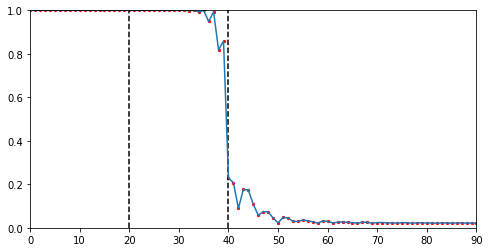

In [585]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = -np.pi
theta_1 = 0
theta_2 = np.pi

n1=20
n2=20
n3=50
xi=4
dis=0.1

p_1 = np.zeros(M+1)
p_2 = np.zeros(M+1)
p_3 = np.zeros(M+1)
p_4 = np.zeros(M+1)

 
p_1[0]=1

# for i in range(n1): 
#     if (i == 0):
#         state = one_step(init_state, theta_1, theta_2)
#     else:
#         state = one_step(state, theta_1, theta_2) 
#     P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_1[i+1] = P1[0] + P1[1] 

# for i in range(n2):
#     t = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i-n2)/xi))       
#     state = one_step(state, t+random.uniform(-dis,dis), theta_2)
#     P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_1[i+n1+1] = P1[0] + P1[1] 
    
# for i in range(n3):
#     t = 1/2 * (theta_3+theta_1 + (theta_3-theta_1) * np.tanh((i+1)/xi))     
#     state = one_step(state, t+random.uniform(-dis,dis), theta_2)   
#     P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_1[i+n1+n2+1] = P1[0] + P1[1]

for i in range(n1): 
    if (i == 0):
        state = one_step(init_state, theta_1, theta_2)
    else:
        state = one_step(state, theta_1, theta_2) 
    P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_1[i+1] = P1[0] + P1[1] 

for i in range(n2):
    t = 1/2 * (theta_3+theta_2 + (theta_3-theta_2) * np.tanh((i-n2)/xi))       
    state = one_step(state, theta_1, t)
    P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_1[i+n1+1] = P1[0] + P1[1] 
    
for i in range(n3):
    t = 1/2 * (theta_3+theta_2 + (theta_3-theta_1) * np.tanh((i+1)/xi))     
    state = one_step(state, theta_1, t)   
    P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_1[i+n1+n2+1] = P1[0] + P1[1]    
    
plt.figure(figsize=(8,4))
T = range(n1+n2+n3+1)
plt.plot(T, p_1[0:n1+n2+n3+1] )
plt.scatter(T, p_1[0:n1+n2+n3+1], s=5, c='r')
plt.xlim((0,n1+n2+n3))
plt.ylim(top = 1,bottom = 0)
# my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
# # plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# # plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# # plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(n1, 0, 1, linestyles = "dashed")
plt.vlines(n1+n2, 0, 1, linestyles = "dashed")

# plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# # plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# # plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed")


In [552]:
from ipywidgets import interact, interactive, fixed, interact_manual 
import ipywidgets as widgets 

import matplotlib.pyplot as plt 
%matplotlib inline 

import numpy as np 

M = 100

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

plt.figure()


def plot_func(n1, n2, theta_1, theta_2, theta_3, xi):
    n1 = int(n1)
    n2 = int(n2)
    state = N_step_ada(init_state, theta_1, theta_2, theta_3, xi, n1, n2)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2 
    phonon = np.arange(0, len(P)) 
    plt.bar(phonon ,P) 
    plt.xlim(0,50)
    plt.ylim(0,1)

interact(plot_func, n1 = widgets.FloatSlider(value=0, 
               min=0, 
               max=89, 
               step=1),n2 = widgets.FloatSlider(value=0, 
               min=0, 
               max=89, 
               step=1),theta_1 = widgets.FloatSlider(value=np.pi/2, 
               min=-2*np.pi, 
               max=2*np.pi, 
               step=0.05*np.pi),theta_2 =widgets.FloatSlider(value=np.pi/2, 
               min=-2*np.pi, 
               max=2*np.pi, 
               step=0.01),theta_3 =widgets.FloatSlider(value=np.pi/2, 
               min=-2*np.pi, 
               max=2*np.pi, 
               step=0.01),chi = widgets.FloatSlider(value=np.pi/2, 
               min=0, 
               max=np.pi)) 
plt.show()

ValueError: cannot find widget or abbreviation for argument: 'xi'

<Figure size 432x288 with 0 Axes>

# 另外一种演化的方式

In [173]:
def N_step_ada(state, theta_1, theta_2, theta_3, xi, n1, n2):
	'''
	N step of complete quantum walk
	'''
	for i in range(n1):    
		state = one_step(state, theta_1, theta_2)   
	for i in range(n2):
		t = theta_3 + (theta_1-theta_3) * np.exp(-(i+1)/xi)    
		state = one_step(state, t, theta_2)
	return state

def N_step_Ada(state, theta_1, theta_2, theta_3, xi, n1, n2):
	'''
	N step of complete quantum walk
	'''
	for i in range(n1):    
		state = one_step(state, theta_1, theta_2)   
	for i in range(n2):
		t = theta_3 + (theta_2-theta_3) * np.exp(-i/xi)     
		state = one_step(state, theta_1, t)
	return state

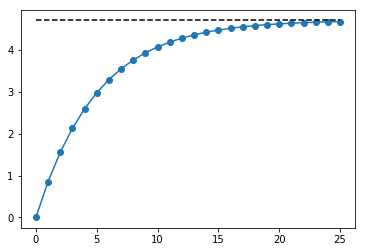

In [235]:
n=25

def f(t, theta_1, theta_2, xi):
    return theta_2 + (theta_1-theta_2) * np.exp(-t/xi)
T = np.linspace(0,n,n+1)
th = np.zeros(n+1)
for i,t in enumerate(T):
    th[i] = f(t, 0, 3*np.pi/2, 5 )
plt.scatter(T,th)
plt.plot(T,th)
plt.hlines(3*np.pi/2, 0, n, linestyles = "dashed")

In [257]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = np.linspace(-3*np.pi/2, 3*np.pi/2, 201)
theta_2 = np.pi/2
theta_1 = 0
xi = 0.5
p_1 = np.zeros(201)
# p_2 = np.zeros(201)
# p_3 = np.zeros(201)
# p_4 = np.zeros(201)

for i,theta in enumerate(theta_3):
    state = N_step_ada(init_state, theta_1, theta_2, theta, xi, n1=20, n2=50)
    P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_1[i] = P1[0] + P1[1] 
#     state = N_step_Ada(init_state, theta_1, theta_2, theta, 1, n1=30, n2=60)
#     P2 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_2[i] = P2[0] + P2[1]
#     state = N_step_Ada(init_state, theta_1, theta_2, theta, 2, n1=30, n2=60)
#     P3 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_3[i] = P3[0] + P3[1]
#     state = N_step_Ada(init_state, theta_1, theta_2, theta, 4, n1=30, n2=60)
#     P4 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_4[i] = P4[0] + P4[1]


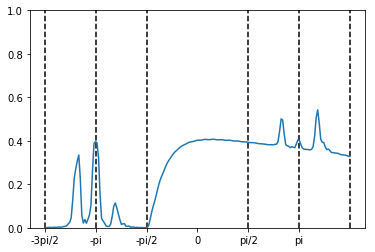

In [258]:
plt.plot(theta_3, p_1)
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-3*np.pi/2,3*np.pi/2,np.pi/2) 
# my_x_ticks = np.arange(-5*np.pi/2,np.pi/2,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.xticks(my_x_ticks,('-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2'))
# plt.xticks(my_x_ticks,('-5pi/2','-2pi','-3pi/2','-pi','-pi/2','0','pi/2'))
# plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-2*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed")


In [248]:
M = 200

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_3 = np.linspace(-3*np.pi/2, 3*np.pi/2, 201)
theta_1 = -np.pi/2
theta_2 = 3*np.pi/8
xi = 6
p_1 = np.zeros(201)
# p_2 = np.zeros(201)
# p_3 = np.zeros(201)
# p_4 = np.zeros(201)

for i,theta in enumerate(theta_3):
    state = N_step_Ada(init_state, theta_1, theta_2, theta, xi, n1=15, n2=30)
    P1 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_1[i] = P1[0] + P1[1] 
#     state = N_step_Ada(init_state, theta_1, theta_2, theta, 1, n1=30, n2=60)
#     P2 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_2[i] = P2[0] + P2[1]
#     state = N_step_Ada(init_state, theta_1, theta_2, theta, 2, n1=30, n2=60)
#     P3 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_3[i] = P3[0] + P3[1]
#     state = N_step_Ada(init_state, theta_1, theta_2, theta, 4, n1=30, n2=60)
#     P4 = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
#     p_4[i] = P4[0] + P4[1]


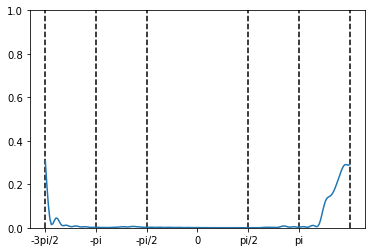

In [249]:
plt.plot(theta_3, p_1)
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-3*np.pi/2,3*np.pi/2,np.pi/2) 
# my_x_ticks = np.arange(-5*np.pi/2,np.pi/2,np.pi/2) 
# plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.xticks(my_x_ticks,('-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2'))
# plt.xticks(my_x_ticks,('-5pi/2','-2pi','-3pi/2','-pi','-pi/2','0','pi/2'))
# plt.xticks(my_x_ticks,('-4pi','-7/2pi','-3pi','-5/2pi','-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi','5/2pi','3pi','7/2pi','4pi'))
# plt.vlines(-7*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(-2*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(2*np.pi, 0, 1, linestyles = "dashed")
# plt.vlines(5*np.pi/2, 0, 1, linestyles = "dashed")
# plt.vlines(7*np.pi/2, 0, 1, linestyles = "dashed")
